In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emanattia","key":"590e6a4b9292b8a86fbe37dabafcdc56"}'}

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

100% 760M/760M [00:07<00:00, 71.3MB/s]



In [ ]:
from zipfile import ZipFile
file_name = "fruits.zip"
with ZipFile(file_name , 'r')as zip:
  zip.extractall()
  print('done')

done


In [ ]:
import pathlib

train_dir = pathlib.Path("/content/fruits-360/Training")
test_dir = pathlib.Path("/content/fruits-360/Test")

In [ ]:
print(train_dir)

/content/fruits-360/Training


In [ ]:
image_count = len(list(train_dir.glob('*/*.jpg')))
#/content/fruits-360/Training/Apple Crimson Snow/0_100.jpg
image_count

67692

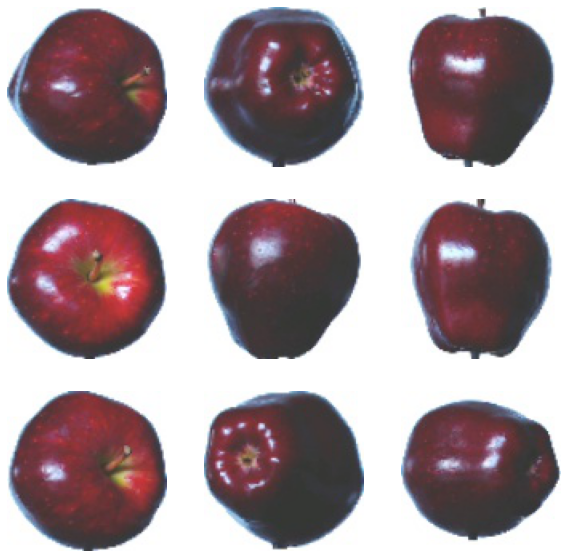

In [ ]:
import matplotlib.pyplot as plt
import PIL

fruits = list(train_dir.glob('Apple Red Delicious/*.jpg'))
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()


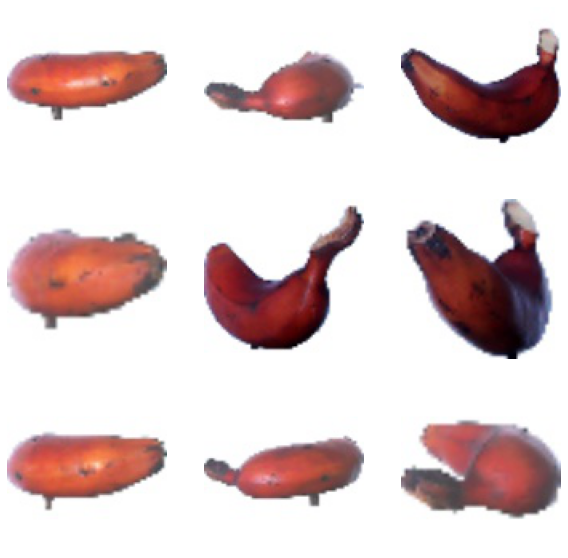

In [ ]:
import matplotlib.pyplot as plt
import PIL

fruits = list(train_dir.glob('Banana Red/*.jpg'))
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()


In [ ]:
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(100, 100),
    batch_size=32
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(100, 100),
    batch_size=32
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [ ]:
class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [ ]:
num_classes

131

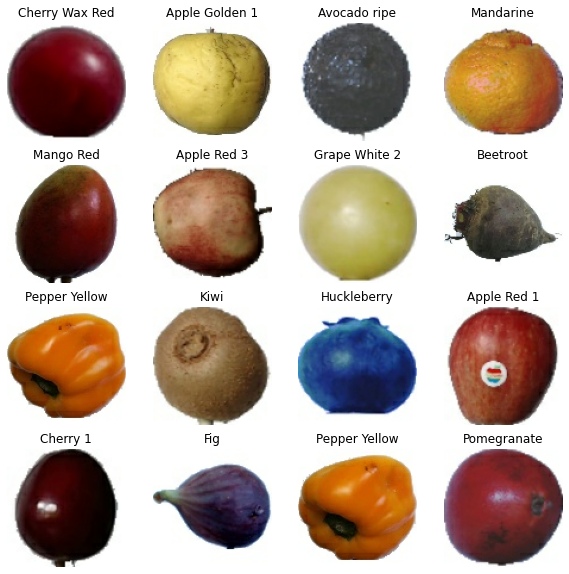

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 100, 100, 3)
(32,)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet'
)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

# Building the Model

In [ ]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

# Training model

In [ ]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

Epoch 1/5
1693/1693 [==============================] - 237s 135ms/step - loss: 0.3979 - accuracy: 0.9014 - val_loss: 0.0389 - val_accuracy: 0.9881
Epoch 2/5
1693/1693 [==============================] - 231s 137ms/step - loss: 0.0559 - accuracy: 0.9860 - val_loss: 0.0032 - val_accuracy: 0.9991
Epoch 3/5
1693/1693 [==============================] - 231s 136ms/step - loss: 0.0449 - accuracy: 0.9894 - val_loss: 0.0159 - val_accuracy: 0.9949
Epoch 4/5
1693/1693 [==============================] - 231s 136ms/step - loss: 0.0289 - accuracy: 0.9928 - val_loss: 0.0137 - val_accuracy: 0.9967
Epoch 5/5
1693/1693 [==============================] - 232s 137ms/step - loss: 0.0263 - accuracy: 0.9933 - val_loss: 0.0157 - val_accuracy: 0.9965


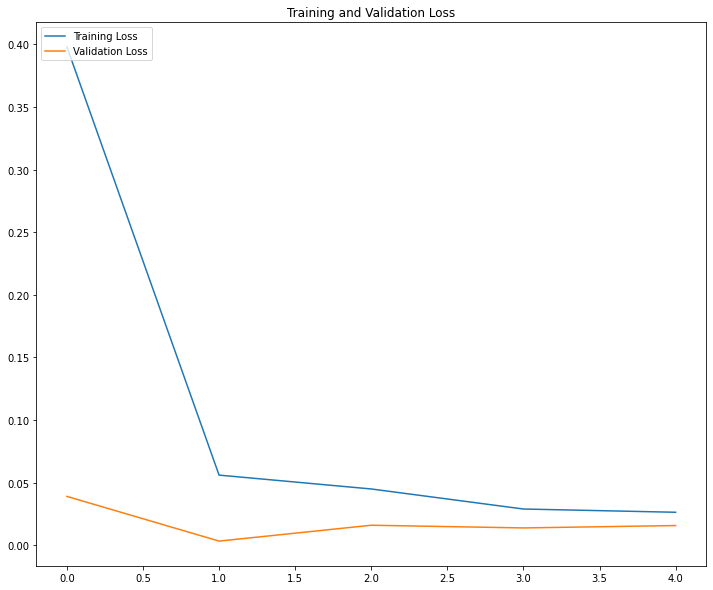

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()